In [1]:
class  BaseModel():
    def __init__(self, model_name = ''):
        
        self.model =  ort.InferenceSession(model_name)
    def preprocess(self, input):
        return input
        
    def run(self, inputs):
        return self.model.run(output_names=[ "output" ], input_feed=dict(inputs))

    def postprocess(self, output):
        return output

In [2]:
import torch

In [3]:
import transformers
transformers.__version__

/home/boss/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


'4.35.2'

# Речь в текст

In [4]:
from optimum.onnxruntime import ORTModelForQuestionAnswering, ORTModelForAudioClassification, ORTModelForSequenceClassification, ORTModelForSpeechSeq2Seq
from transformers import AutoConfig, Wav2Vec2Processor, AutoTokenizer, PretrainedConfig, WhisperProcessor
from transformers import AutoProcessor, AutoModelForCTC,  Wav2Vec2ForCTC, Wav2Vec2Processor
import time
import librosa
import numpy as np
import os

dir_model = '../Base Classification/'
VARIANT = 1
# model_name_speech_to_text = [dir_model+'whisper-tiny_onnx', "openai/whisper-base", "openai/whisper-tiny"]
if VARIANT==0:
    ASP_ONNX = 1
    model_name_speech_to_text = [dir_model+'whisper-tiny_onnx', "openai/whisper-base", "openai/whisper-tiny"]
elif VARIANT==1:
    ASP_ONNX = 0
    model_name_speech_to_text = ["jonatasgrosman/wav2vec2-large-xlsr-53-russian"]*3
print(model_name_speech_to_text)
model_name_speech_to_emo = [dir_model+"wav2vec2-xls-r-300m-emotion-ru_onnx", "KELONMYOSA/wav2vec2-xls-r-300m-emotion-ru"]
model_name_text_to_emo = [dir_model+"rubert-tiny2-russian-emotion-detection_onnx", "Djacon/rubert-tiny2-russian-emotion-detection"]


class  SpeechtoText(BaseModel):
    def __init__(self, model_path, model_name, model_name_preprocess, postprocess = None):
        
        if ASP_ONNX==1:
            self.processor =  WhisperProcessor.from_pretrained(model_name_preprocess)#"openai/whisper-tiny")
            # self.sampling_rate = processor.feature_extractor.sampling_rate
            model_config = PretrainedConfig.from_pretrained(model_name)
            predictions = []
            references = []
            sessions = ORTModelForSpeechSeq2Seq.load_model(
                os.path.join(model_path, 'encoder_model.onnx'),
                os.path.join(model_path, 'decoder_model.onnx'),
                os.path.join(model_path, 'decoder_with_past_model.onnx'))
            self.model = ORTModelForSpeechSeq2Seq(sessions[0], sessions[1], model_config, model_path, sessions[2])
            self.forced_decoder_ids = self.processor.get_decoder_prompt_ids(language="russian", task="transcribe")
        else:
            print('MODEL TORCH 0',model_path)
            self.processor = Wav2Vec2Processor.from_pretrained(model_path)
            print('MODEL TORCH 00000000')
            self.model = Wav2Vec2ForCTC.from_pretrained(model_path)
            print('MODEL TORCH ***************************************')
            self.forced_decoder_ids = lambda x: self.processor.batch_decode(torch.argmax(x, dim=-1))
            print('MODEL TORCH OK')
        if  postprocess is not None:
            self.post_process =  postprocess
        else:
            self.post_process = None
        self.sampling_rate = 16000
        self.onnx = ASP_ONNX
    def postprocess(self, output):
        if self.onnx:
            output = self.processor.batch_decode(output, skip_special_tokens=True)
        else:
            output = self.forced_decoder_ids(output)
        return output
        
    def run(self, speech):
        # speech # речевой отрывок

        def speech_file_to_array_fn(batch):
            speech_array, sampling_rate = librosa.load(batch["path"], sr=16_000)
            batch["speech"] = speech_array
            batch["sentence"] = batch["sentence"].upper()
            return batch

        
        # with torch.no_grad():
        #     logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

        print('feature run: ******************')
        feature = self.processor(speech, sampling_rate=self.sampling_rate, return_tensors="pt")
        print('features :',feature.keys())
        print(self.onnx)
        if self.onnx:
            rez = self.model.generate(feature['input_features'], forced_decoder_ids=self.forced_decoder_ids)
        else:
            
            rez = self.model(feature.input_values, attention_mask=feature.attention_mask).logits
            
        
        return self.postprocess(rez)
# class  SpeechtoText(BaseModel):
#     def __init__(self, model_path, model_name, model_name_preprocess, postprocess = None):
#         self.processor =  WhisperProcessor.from_pretrained(model_name_preprocess)#"openai/whisper-tiny")
#         # self.sampling_rate = processor.feature_extractor.sampling_rate
#         model_config = PretrainedConfig.from_pretrained(model_name)
#         predictions = []
#         references = []
#         sessions = ORTModelForSpeechSeq2Seq.load_model(
#             os.path.join(model_path, 'encoder_model.onnx'),
#             os.path.join(model_path, 'decoder_model.onnx'),
#             os.path.join(model_path, 'decoder_with_past_model.onnx'))
#         self.model = ORTModelForSpeechSeq2Seq(sessions[0], sessions[1], model_config, model_path, sessions[2])
#         self.forced_decoder_ids = self.processor.get_decoder_prompt_ids(language="russian", task="transcribe")
#         if  postprocess is not None:
#             self.post_process =  postprocess
#         else:
#             self.post_process = None
#         self.sampling_rate = 16000
#     def postprocess(self, output):

#         output = self.processor.batch_decode(output, skip_special_tokens=True)
#         return output
        
#     def run(self, speech):
#         feature = self.processor(speech, sampling_rate=self.sampling_rate, return_tensors="pt")
#         rez = self.model.generate(feature['input_features'], forced_decoder_ids=self.forced_decoder_ids)
#         # print(rez.logits[0], self.emotions)
#         return self.postprocess(rez)

# sampling_rate =  16000
# path_a ='01_happiness_anger a_020.wav'
# speech, sr = librosa.load(path_a, sr=sampling_rate)
# model_text = SpeechtoText('whisper-tiny_onnx', "openai/whisper-base", "openai/whisper-tiny")
# model_text.run(speech)



2024-09-13 16:06:29.393977: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 16:06:29.584280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 16:06:29.679227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 16:06:29.679902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 16:06:29.831575: I tensorflow/core/platform/cpu_feature_gua

['jonatasgrosman/wav2vec2-large-xlsr-53-russian', 'jonatasgrosman/wav2vec2-large-xlsr-53-russian', 'jonatasgrosman/wav2vec2-large-xlsr-53-russian']


/home/boss/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
print('START speech model')
model_asp = SpeechtoText(model_name_speech_to_text[0],model_name_speech_to_text[1], model_name_speech_to_text[2], postprocess = None)
print('end speech model start')

/home/boss/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


START speech model
MODEL TORCH 0 jonatasgrosman/wav2vec2-large-xlsr-53-russian
MODEL TORCH 00000000
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-russian were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-russian and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
Y

MODEL TORCH ***************************************
MODEL TORCH OK
end speech model start


In [6]:
sampling_rate =  16000
path_a ='01_happiness_anger a_020.wav'
speech, sr = librosa.load(path_a, sr=sampling_rate)
model_asp.run(speech)

feature run: ******************
features : dict_keys(['input_values', 'attention_mask'])
0


['слушая потратила при этом кучу динег для того чтоб притащиться в эту дру это что о бсе такую постринно официантов они всех черных каких-то рубашках с кислыми минами даже никто из них до сих пор не подошел к нам']

# Речь в эмоции

In [13]:

class  SpeechtoEmotion(BaseModel):
    def __init__(self, model_name, model_name_preprocess, model_postprocess = None):
        self.processor = Wav2Vec2Processor.from_pretrained(model_name_preprocess)
        self.sampling_rate = self.processor.feature_extractor.sampling_rate
        self.model = ORTModelForAudioClassification.from_pretrained(model_name)#"wav2vec2-xls-r-300m-emotion-ru_onnx"
        self.emotions = ['neutral', 'positive', 'angry', 'sad', 'other']
        if  model_postprocess is not None:
            self.post_process =  model_postprocess
        else:
            self.post_process = None
    
    def postprocess(self, outputs):
        return self.emotions[np.argmax(outputs.logits[0])]
        
    def run(self, speech):
        features = self.processor(speech, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True)
        rez = self.model(features['input_values'])
        # print(rez.logits[0], self.emotions)
        return self.postprocess(rez)
sampling_rate = 16000

path_a ='01_happiness_anger a_020.wav'
speech, sr = librosa.load(path_a, sr=sampling_rate)
model_em = SpeechtoEmotion("wav2vec2-xls-r-300m-emotion-ru_onnx", "KELONMYOSA/wav2vec2-xls-r-300m-emotion-ru")
model_em.run(speech)

/home/boss/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


'angry'

# Текст в эмоции

In [5]:
class  TexttoEmotion(BaseModel):
    def __init__(self, model_name, model_name_or_path):
        self.processor = AutoTokenizer.from_pretrained(model_name_or_path)
        self.model = ORTModelForSequenceClassification.from_pretrained(model_name)
        self.labels = ['neutral', 'joy', 'sadness', 'anger', 'enthusiasm', 'surprise', 'disgust', 'fear', 'guilt', 'shame']
        self.labels_ru = ['нейтрально', 'радость', 'грусть', 'гнев', 'интерес', 'удивление', 'отвращение', 'страх', 'вина', 'стыд']
    
    def postprocess(self, outputs):
        return self.labels[np.argmax(outputs.logits[0])]
        
    def run(self, text):
        features = self.processor(text,  max_length=512, truncation=True, return_tensors='pt')
        rez = self.model(**features)
        # print(features )
        return self.postprocess(rez)


model_textem = TexttoEmotion("rubert-tiny2-russian-emotion-detection_onnx", "Djacon/rubert-tiny2-russian-emotion-detection")
model_textem.run("ой беда, какая беда")

'sadness'

## Общий поток распознавания

In [10]:
path_a ='01_happiness_anger a_020.wav'
path_a = '1725.wav'

speech, sr = librosa.load(path_a, sr=sampling_rate)
# создаем модели
model_text = SpeechtoText('whisper-tiny_onnx', "openai/whisper-base", "openai/whisper-tiny")
model_textem = TexttoEmotion("rubert-tiny2-russian-emotion-detection_onnx", "Djacon/rubert-tiny2-russian-emotion-detection")
model_em = SpeechtoEmotion("wav2vec2-xls-r-300m-emotion-ru_onnx", "KELONMYOSA/wav2vec2-xls-r-300m-emotion-ru")
# длина эпизода записи в с. 
dt = 5
d = 16000 * dt
rez_text_all = model_text.run(speech)
rez_text_all_buf = rez_text_all[0] 
rez_text_all_list = rez_text_all[0].split(' ')
rez_all_result = []
l_speech = int(len(rez_text_all_buf) / (len(speech)/d * 2) )
# распознавание
for t, speech_i in enumerate(range(0,speech.shape[0], d//2)):
    t1 = time.time()
    speech_d = speech[speech_i:speech_i+d]
    rez_text = model_text.run(speech_d)
    print(rez_text)
    for s in rez_text[0].split():
        k = rez_text_all_buf.find(s)
        print(end=s)
        if k >=0:
            rez_text_all_buf = rez_text_all_buf[k:]
            
            rez_word = s
            break
    rez_em_text = model_textem.run(rez_text)

    
    rez_em_speech = model_em.run(speech_d)
    # запись результата : время, текст, слово для привязки времени, эмоция по тексту, Эмоция по звуку
    rez_all_result.append( [t * float(dt) / 2, rez_text[0], rez_word , rez_em_text, rez_em_speech])    
    print('Time: ',time.time() - t1)
    print('Result text: ',rez_text)
    print('Result emotion: ', rez_em_text, rez_em_speech)




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type whisper to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
[' Никто не может изменить прошлое. Надо жить настоящим и смотреть в будущее.']
НиктоTime:  0.8898952007293701
Result text:  [' Никто не может изменить прошлое. Надо жить настоящим и смотреть в будущее.']
Result emotion:  neutral positive
[' Надо жить настоящим и смотреть в будущее.']
НадожитьTime:  0.7165782451629639
Result text:  [' Надо жить настоящим и смотреть в будущее.']
Result emotion:  joy positive
[' Добящее.']
Добящее.Time:  0.5187745094299316
Result text:  [' Добящее.']
Result emotion:  neutral angry


In [11]:
rez_all_result 


[[0.0,
  ' Никто не может изменить прошлое. Надо жить настоящим и смотреть в будущее.',
  'Никто',
  'neutral',
  'positive'],
 [2.5,
  ' Надо жить настоящим и смотреть в будущее.',
  'жить',
  'joy',
  'positive'],
 [5.0, ' Добящее.', 'жить', 'neutral', 'angry']]

In [12]:
import pandas as pd
pd.DataFrame(rez_all_result , columns= ['t', 'sub_string', 'word', 'em1', 'em2'])#.to_csv(path_a.split('/')[-1].split('.')[0] +  '.csv')

,t,sub_string,word,em1,em2
0,0.0,Никто не может изменить прошлое. Надо жить на...,Никто,neutral,positive
1,2.5,Надо жить настоящим и смотреть в будущее.,жить,joy,positive
2,5.0,Добящее.,жить,neutral,angry


# Текст в эмоции Fine-tuning 

## загружаем модель из претрейна
- загрузить
- проверить работу
- посмотреть на входы выходы рабочей части модели


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torchvision
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

tokenizer = AutoTokenizer.from_pretrained("Djacon/rubert-tiny2-russian-emotion-detection")
model = AutoModelForSequenceClassification.from_pretrained("Djacon/rubert-tiny2-russian-emotion-detection")
input = tokenizer("ой беда, какая беда", padding=True, truncation=True, return_tensors='pt')
predict = model(input['input_ids'], input['attention_mask'])
predict

SequenceClassifierOutput(loss=None, logits=tensor([[-2.1391, -2.8492,  1.7666,  0.2717, -3.0771, -2.4219, -0.5103, -1.8227,
         -1.0535, -1.0158]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Планируем работать с моделью на русском -> взяли модель из русского языка. 

Для любой модели из языковых в состав модели входит:

    - токенизатор : его задача разбить входной текст на слова и получить токены(индексы слов или кусков слов)
    - сама модель : берет послеорваительность токенов и делает классификацию на n классов
    - иногда есть явный постпроцесинг (превратить ответ модели в что-то интерпретируемое ) , иногда мы его делаем сами (как в модели текст-эмоция))

    текущий вход для основной модели:

In [6]:
input

{'input_ids': tensor([[    2, 23983, 45926,    16, 31126, 45926,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

Текущий выход модели : из 3х элементов. Нам нужен "logits"

In [7]:
predict 

SequenceClassifierOutput(loss=None, logits=tensor([[-2.1391, -2.8492,  1.7666,  0.2717, -3.0771, -2.4219, -0.5103, -1.8227,
         -1.0535, -1.0158]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [8]:
predict["logits"]

tensor([[-2.1391, -2.8492,  1.7666,  0.2717, -3.0771, -2.4219, -0.5103, -1.8227,
         -1.0535, -1.0158]], grad_fn=<AddmmBackward0>)

Модель вернула 10 значений ответов (т.е. классификатор работает на 10 классов). Нам нужен классификатор на 2 класса (ну или на сколько нам нужно). Посмотреть  на выход модели можно просто через вывод: print(model)

In [15]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

Наш кусок для адаптации : (classifier): Linear(in_features=312, out_features=10, bias=True)

посмотрит только на него:

In [16]:
model.classifier

Linear(in_features=312, out_features=10, bias=True)

Посмотрим на его параметры:

In [11]:
for p in model.classifier.parameters():
    print(p.shape)

torch.Size([10, 312])
torch.Size([10])


Теперь исправим выход модели по своему заданию.

## заменить слой на свой по заданному размеру выхода (у нас 2 класса -> один выход (сигмоид или линейная модель))

In [12]:
model.classifier = torch.nn.Linear(312, 1, bias=True)

## metrica (нам нужна классификация, т.е. метрика классификационного типа)

In [17]:
criteriy_SA = torch.nn.BCELoss()
def acc(yp,yt):
    return (yp==yt).float().mean()
metric = acc

## датасет для обучения

собирает данные в пакет : вход модели-выход модели для каждого примера

In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, list_col=['text','label'], class_list = {0:['enthusiasm', 'happiness', 'neutral'], 1:['anger', 'disgust', 'fear', 'sadness']}):
        '''
        df, - датафрейм для работы с данными (маршруты или сами значения и метки)
        list_col=['text','label'], - список актуальных колонок датафрейма для работы (в каждом наборе данных и каждой задаче свое)
        class_list = {0:['enthusiasm', 'happiness', 'neutral'], 1:['anger', 'disgust', 'fear', 'sadness']} - словарь распределения разметки эмоций 
                                                                                                              из датафрейма в разметку датасета 
                                                                                                              (2 эмоции в этом варианте : 
                                                                                                              норма и не норма)
        
        
        '''
        
        super(MyDataset).__init__( )
        
        # assert df.shape[0] > 0, "this ok"
        self.slen = df.shape[0]
        self.data = df.loc[:, list_col]
       
        self.class1 = class_list[0]
        self.class2 = class_list[1]
        
    def __getitem__(self, index):
        """
        извлекаем пару : Х, у
        """
        text, label_text = self.data.iloc[index, :]
        if label_text in self.class1:
            label = 0
        else:
            label = 1
            
        return text, label
    def __len__(self):
        """
        вернет длину датасета
        """
        return self.slen
# читаем датафреймы
df = pd.read_csv('../TZ_noisa/train.csv')
df_test = pd.read_csv('../TZ_noisa/test.csv')



текущие эмоции из разметки:

In [19]:
df.emotion.unique()

array(['happiness', 'disgust', 'anger', 'fear', 'enthusiasm', 'neutral',
       'sadness'], dtype=object)

### балансировка по схеме новых данных:

{0:['enthusiasm', 'happiness', 'neutral'], 1:['anger', 'disgust', 'fear', 'sadness']}

In [20]:
df.emotion.value_counts()

emotion
fear          178
anger         175
happiness     174
enthusiasm    158
neutral       153
disgust       148
sadness       130
Name: count, dtype: int64

Новые классы:

In [22]:
new_class = {0:['enthusiasm', 'happiness', 'neutral'], 1:['anger', 'disgust', 'fear', 'sadness']}

Число примеров в новых классах:

In [23]:
class0t = df_test.emotion.value_counts().loc[new_class[0]].sum()
print(class0t)
class1t = df_test.emotion.value_counts().loc[new_class[1]].sum()
print(class1t)

122
158


In [24]:
class0 = df.emotion.value_counts().loc[new_class[0]].sum()
print(class0)
class1 = df.emotion.value_counts().loc[new_class[1]].sum()
print(class1)

485
631


In [25]:
class1-class0

146

Не сбалансированы!!!!! 

In [26]:
df.head()

,name,path,emotion,text
0,32_happiness_enthusiasm_h_120,happiness_enthusiasm_32/32_happiness_enthusias...,happiness,"Конечно, расскажу, обязательно. Ой, сейчас рас..."
1,36_disgust_happiness_d_130,disgust_happiness_36/36_disgust_happiness_d_13...,disgust,Вы ещё и профессию решили поменять.
2,34_anger_fear_a_060,anger_fear_34/34_anger_fear_a_060.wav,anger,"Ты знаешь, чем это для тебя закончится?"
3,25_anger_disgust_a_010,anger_disgust_25/25_anger_disgust_a_010.wav,anger,Добрый день. Вы хотели бы приобрести недвижимо...
4,17_neutral_disgust_d_092,neutral_disgust_17/17_neutral_disgust_d_092.wav,disgust,"все ваши рекламные акции, пожалуйста, больше н..."


## undersumpling
уберем примеры из большего класса  df_test

In [27]:

samples_fraq =class0t/class1t

print('берем примеров:' ,samples_fraq )

ddf = []
for name in new_class[1]:
    d_f = df_test.loc[df_test.emotion == name, :]
    ddf += [ d_f.sample(frac=samples_fraq) ]
for name in new_class[0]:
    d_f = df_test.loc[df_test.emotion == name, :]
    ddf += [ d_f]    

df_test = pd.concat( ddf, axis=0)

# # проверка
class0t = df_test.emotion.value_counts().loc[new_class[0]].sum()
print(class0t)
class1t = df_test.emotion.value_counts().loc[new_class[1]].sum()
print(class1t)

берем примеров: 0.7721518987341772
122
123


Oversampling:
    
    - добавим примеров меньшего класса

In [28]:
# разница между классами
add_samples = class1-class0
add_samples 

146

In [29]:
# число классовМетрика
c1 = len(new_class[0])
c1

3

Делаем добавку за счет случайных примеров  - равномерно по всем типам

In [30]:
ddf = []


print('добавим примеров:' ,add_samples )
for name in new_class[0]:
    d_f = df_test.loc[df_test.emotion == name, :]
    # try:
    if 1:
        ddf += [ d_f.iloc[np.random.randint(0, d_f.shape[0],(add_samples // c1) ).tolist(), :]]
    # except:
    #     print(name, d_f.shape)
df = pd.concat([df]+ddf, axis=0)

# проверка
class0 = df.emotion.value_counts().loc[new_class[0]].sum()
print(class0)
class1 = df.emotion.value_counts().loc[new_class[1]].sum()
print(class1)

добавим примеров: 146
629
631


## Создаем датасеты из датафреймов

In [31]:

# создаем датасеты
ds = MyDataset(df,['text','emotion'])
ds_test = MyDataset(df_test,['text','emotion'])

### проверяем датасеты

In [32]:
for data in ds_test:
    print(data)
    break

('Хорошо.', 1)


Все ок

### создаем загрузку данных

особый класс для сборки пакетов DataLoader. Создаем 2 экземпляра для тренировки и теста

In [58]:
torch.utils.data.get_worker_info()

In [33]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

data_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, num_workers=1)
data_loader_test = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=True, num_workers=1)

for data in data_loader_test:
    print(data)
    break

[('А что мы сегодня сдаём? Бек, по-моему, да?', 'Здравствуйте, ну я хотел бы самый лучший, как и у вас там есть, не знаю, какие самые большие скажите мне', 'Давай пуляй. Три, два, один!', 'Мы сделаем всё возможное. Итак, мы перепроверили все ваши данные, всё зафиксировали. Извините, пожалуйста, последний вопрос. Если вы хотите до квартиры, то ваш адрес.', 'Хорошо, какие у вас будут пожелания к нашему занятию?', 'Я думал, ты мне поможешь, я думал, что я как бы это всё профинансирую, а ты, может быть, сама узнаешь, посмотришь, полазишь по интернету.', 'Вы так здорово рассказываете, мне уже хочется устроить здесь какую-нибудь вечеринку. Я даже уже представляю когда. Скоро ведь кухня уже готова. А расскажите мне, как вам?', 'А я, представь себе, нет!', 'Ну это же прикольно!', 'Ну вот так решайте эту проблему!', 'Послушайте, за минут 30 вы вряд ли соберете заказ, вряд ли это мне доставит до моего дома.', 'Подождите, сейчас посмотрю. 008', 'Ну какой контроль? Ну какой контроль, если я не зна

## Создаем оптимизатор и функциию , которая оценивает потери при обучении

In [34]:
model.classifier = torch.nn.Linear(312, 1, bias=True)

In [35]:
opt = torch.optim.Adam(model.classifier.parameters(), lr= 0.001)
criteriy_SA = torch.nn.BCELoss()
history_train = []
history_test = []
count = 0

## ЦИКЛ ОБУЧЕНИЯ

    - ЭТО "голый" torch процесс обучения : определить цикл по эпохам, определить цикл по данным, очистить оптимизатор, прямой проход, потери, обратный проход, шаг оптимизатора, по итогам эпохи тест.
    - можно брать разные пакеты "обложки": https://github.com/Lightning-AI/pytorch-lightning

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:

for epoch in range(10):#цикл по эпохам
    for data in data_loader:# цикл по данным
        text, label = data[0], data[1]
        opt.zero_grad()# очистить оптимизатор

        # прямой проход
        input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        out = model(input['input_ids'], input['attention_mask'])
        # print(out)
        # потери
        loss = criteriy_SA(torch.nn.functional.sigmoid(out['logits'].reshape(-1)),label.float()  )
        # обратный проход
        loss.backward()
        # шаг оптимизатора
        opt.step()
        # пишем историю обучения
        history_train.append([loss.item()])
        count += 1
        print(end='.')
    accuracy_test = []  
    loss_test = []
    # по итогам эпохи тест
    for data in data_loader_test:
        text, label = data[0], data[1]
        
        input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        out = model(input['input_ids'], input['attention_mask'])
        loss_test.append(criteriy_SA(torch.nn.functional.sigmoid(out['logits'].reshape(-1)),label.float()  ).item())
        accuracy_test.append(metric((out['logits'].reshape(-1)>0).float(),label.float() ))
    # пишем историю тестов
    history_test.append([count, np.mean(accuracy_test), np.mean(loss_test)]) 
    print('epoch :', epoch, ' , [train loss: ', np.mean(history_train[-10:]), ',  test accuracy: ', np.mean(accuracy_test), ' , loss_test : ',  np.mean(loss_test),']')
    
    

..........epoch : 0  , [train loss:  0.6905940473079681 ,  test accuracy:  0.58186436  , loss_test :  0.6675047874450684 ]
..........epoch : 1  , [train loss:  0.6603398740291595 ,  test accuracy:  0.6294738  , loss_test :  0.6448643505573273 ]
..........epoch : 2  , [train loss:  0.6482373654842377 ,  test accuracy:  0.6439971  , loss_test :  0.6377277076244354 ]
..........epoch : 3  , [train loss:  0.6471140384674072 ,  test accuracy:  0.65938836  , loss_test :  0.634610116481781 ]
..........epoch : 4  , [train loss:  0.6457428395748138 ,  test accuracy:  0.6479033  , loss_test :  0.6332189440727234 ]
..........epoch : 5  , [train loss:  0.645086532831192 ,  test accuracy:  0.65645033  , loss_test :  0.634072333574295 ]
..........epoch : 6  , [train loss:  0.6430573225021362 ,  test accuracy:  0.65902114  , loss_test :  0.6318776309490204 ]
..........epoch : 7  , [train loss:  0.6412001073360443 ,  test accuracy:  0.6543803  , loss_test :  0.631415992975235 ]
..........epoch : 8  , [

## визуализация результата

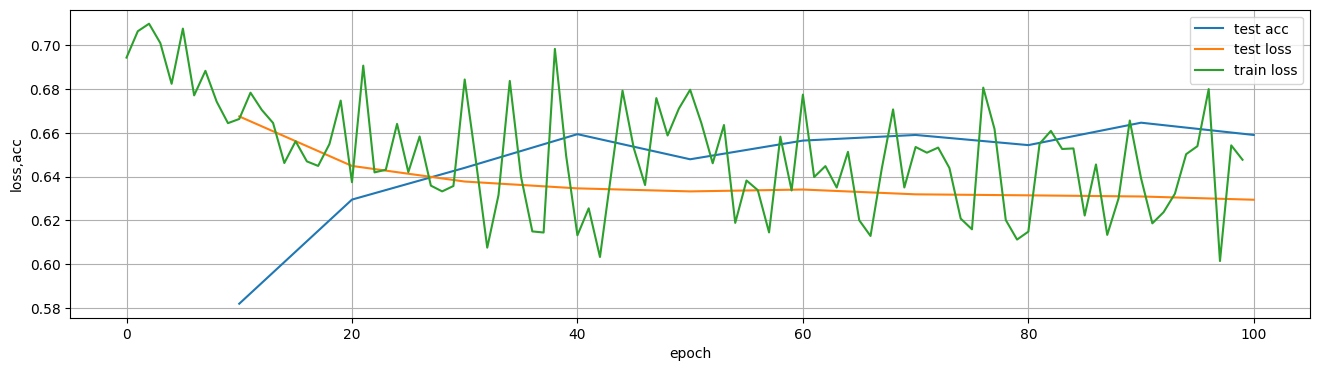

In [38]:
history_test =  np.array(history_test)
history_train = np.array(history_train)

plt.figure(figsize=(16,4))
plt.plot(history_test[:,0], history_test[:,1 ] , label='test acc') 
plt.plot(history_test[:,0], history_test[:,2] , label='test loss') 
plt.plot(history_train, label='train loss') 
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss,acc')
plt.show()

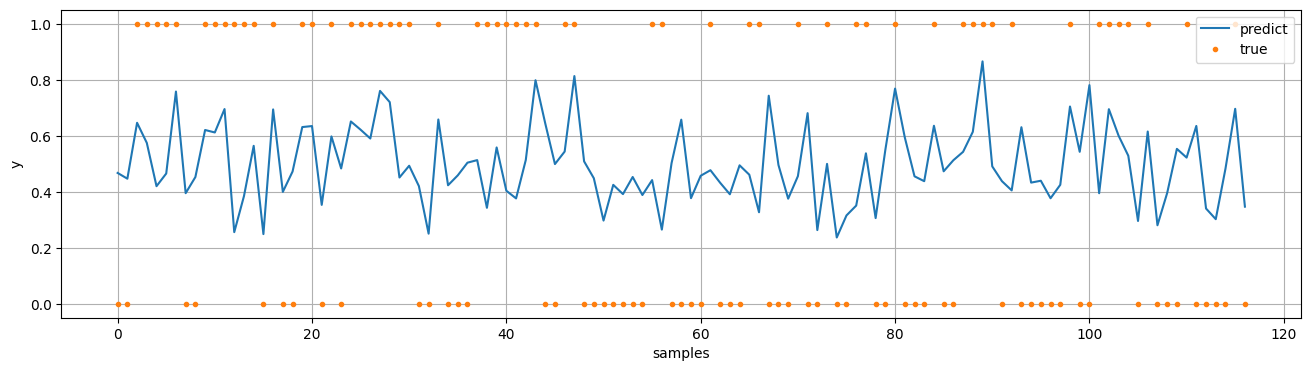

In [39]:
plt.figure(figsize=(16,4))
plt.plot(torch.nn.functional.sigmoid(out['logits'].reshape(-1)).detach().cpu().numpy(), label='predict')
plt.plot(label.numpy(),'.',  label='true')
plt.grid()
plt.xlabel('samples')
plt.ylabel('y')
plt.legend()
plt.show()

In [74]:
np.mean(accuracy_test)

0.6244658

## Калибровка модели

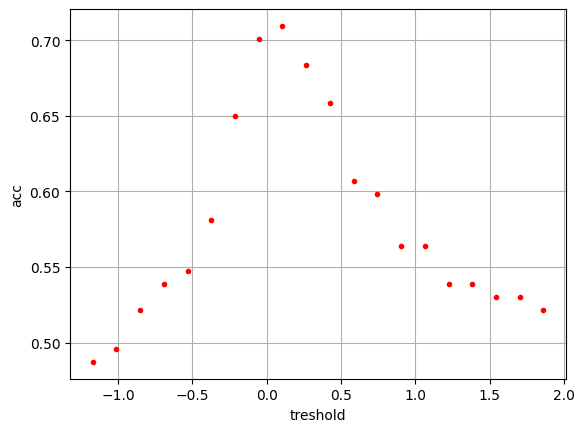

In [40]:
min_y = out['logits'].reshape(-1).min().item()
max_y = out['logits'].reshape(-1).max().item()
for tr in np.linspace(min_y, max_y, 20):
    acc = metric((out['logits'].reshape(-1)>tr).float(),label.float() )
    plt.plot(tr, acc, '.r')
plt.grid()
plt.xlabel('treshold')
plt.ylabel('acc')

plt.show()    

# модель ASR

Метрика

In [91]:
def calculate_wer(reference, hypothesis):
	ref_words = reference.split()
	hyp_words = hypothesis.split()
	# Counting the number of substitutions, deletions, and insertions
	substitutions = sum(1 for ref, hyp in zip(ref_words, hyp_words) if ref != hyp)
	deletions = len(ref_words) - len(hyp_words)
	insertions = len(hyp_words) - len(ref_words)
	# Total number of words in the reference text
	total_words = len(ref_words)
	# Calculating the Word Error Rate (WER)
	wer = (substitutions + deletions + insertions) / total_words
	return wer

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
from transformers import pipeline
import time
import librosa
import numpy as np
import pandas as pd
import os

from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from datasets import Dataset
import torch

from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()

processor = AutoProcessor.from_pretrained("Shirali/whisper-small-ru")
model = AutoModelForSpeechSeq2Seq.from_pretrained("Shirali/whisper-small-ru")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


df = pd.read_csv('../dataset/RESD_csv/test.csv')
print(df.head())
ds = Dataset.from_pandas(df)



class  SpeechtoText_all():
    def __init__(self, model_name= "Shirali/whisper-small-ru", train=False, new_out_features = 51865):
        # self.processor = AutoProcessor.from_pretrained(model_name)
        # self.model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)
        self.processor = WhisperProcessor.from_pretrained(model_name)

        self.model = WhisperForConditionalGeneration.from_pretrained(model_name)
        
        if train:
            self.model.config.use_cache = False
            self.model.generate = partial(model.generate, language="rgd", task="transcribe", use_cache=True)

            

        self.training_args = Seq2SeqTrainingArguments(
                output_dir="./whisper-small-rgd",  # name on the HF Hub
                per_device_train_batch_size=16,
                gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
                learning_rate=1e-5,
                lr_scheduler_type="constant_with_warmup",
                warmup_steps=50,
                max_steps=500,  # increase to 4000 if you have your own GPU or a Colab paid plan
                gradient_checkpointing=True,
                # fp16=True,
                # fp16_full_eval=True,
                evaluation_strategy="steps",
                per_device_eval_batch_size=16,
                predict_with_generate=True,
                generation_max_length=225,
                save_steps=500,
                eval_steps=500,
                logging_steps=25,
                # report_to=["tensorboard"],
                report_to = [], 
                load_best_model_at_end=True,
                metric_for_best_model="wer",
                greater_is_better=False,
                push_to_hub=True,
                )

        self.forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")
        self.get_prompt_ids = processor.get_prompt_ids
    
    def prepare_dataset(self, batch, sp):
        # load and resample audio data from 48 to 16kHz
        audio = batch["audio"]
    
        # compute log-Mel input features from input audio array 
        batch["input_features"] = feature_extractor(audio, sampling_rate=sp).input_features[0]
    
        # encode target text to label ids 
        batch["labels"] = tokenizer(batch["sentence"]).input_ids
        return batch    

    def postprocess(self, output):
        return output[0]
        
    def run(self, speech, sr):
        rez = self.processor(speech, sampling_rate=sr, return_tensors="pt").input_features
        rez = model.generate(rez, forced_decoder_ids=self.forced_decoder_ids)
        return self.postprocess(self.processor.batch_decode(rez, skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


                            name  \
0          27_neutral_fear_n_100   
1         08_sadness_anger a_010   
2  26_enthusiasm_happiness_e_120   
3            42_anger_fear_a_190   
4       04_fear_enthusiasm f_090   

                                                path     emotion  \
0          neutral_fear_27/27_neutral_fear_n_100.wav     neutral   
1        08_sadness_anger/08_sadness_anger a_010.wav       anger   
2  enthusiasm_happiness_26/26_enthusiasm_happines...  enthusiasm   
3              anger_fear_42/42_anger_fear_a_190.wav       anger   
4    04_fear_enthusiasm/04_fear_enthusiasm f_090.wav        fear   

                                                text  
0  Вам дадут целый минимальный оклад, но при этом...  
1                             Сколько можно звонить?  
2           А как долго тебе нужно это всё узнавать?  
3             Ну а мне в 5 часов вставать на работу!  
4  Честно, я не подскажу, ну как и обычно, любым ...  


In [9]:
sampling_rate =  16000
path_a ='01_happiness_anger a_020.wav'
speech, sr = librosa.load(path_a, sr=sampling_rate)
model_text = SpeechtoText_all(model_name= "Shirali/whisper-small-ru")
text = model_text.run(speech, sr)

model_text.get_prompt_ids(text)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


array([50361,  2933, 43689,    11,  2552,  6364, 11157,  2338,  5082,
       10755,   981,  4187,   585, 40957,  5561, 11283,  7887,  1285,
       30816,  2000, 12306,   740, 18763,  1070,  2711,    11,  2691,
        2143, 14345, 18292,    30, 18689, 44443,  1470, 31950, 30321,
        1416,  8642,    11,  7515,  4640,   740,  1358, 24134,  5783,
       44178,    12,   860, 27371,  6835, 18366,   776,   981, 47105,
       24670, 19073,  5150,    11, 11210, 31666,  3943, 14319,  5865,
         776,  4165, 11948,  1725,  4095,  6824, 24180,   981, 11401,
          13])

In [14]:
from transformers import AutoModelForCTC, TrainingArguments, Trainer, WhisperForConditionalGeneration,  WhisperProcessor, WhisperTokenizer

# feature_extractor = WhisperFeatureExtractor.from_pretrained("Shirali/whisper-small-ru")
# tokenizer = WhisperTokenizer.from_pretrained("Shirali/whisper-small-ru", language="russian", task="transcribe")

processor = WhisperProcessor.from_pretrained("Shirali/whisper-small-ru", language="russian", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(  "Shirali/whisper-small-ru",)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
text_

{'input_features': [array([[-0.16204023, -0.03413689, -0.07214582, ..., -0.61436117,
        -0.61436117, -0.61436117],
       [-0.15291369, -0.11161578, -0.08367753, ..., -0.61436117,
        -0.61436117, -0.61436117],
       [-0.3167392 , -0.24272668, -0.14408207, ..., -0.61436117,
        -0.61436117, -0.61436117],
       ...,
       [-0.61436117, -0.61436117, -0.61436117, ..., -0.61436117,
        -0.61436117, -0.61436117],
       [-0.61436117, -0.61436117, -0.61436117, ..., -0.61436117,
        -0.61436117, -0.61436117],
       [-0.61436117, -0.61436117, -0.61436117, ..., -0.61436117,
        -0.61436117, -0.61436117]], dtype=float32)]}

In [16]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny", language="russian")


tokenizer.set_prefix_tokens(language="russian")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


WhisperTokenizer(name_or_path='openai/whisper-tiny', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|>', '<|el|>', '<|ms|>', '<|cs|>', '<|ro|>', '<|da|>', '<|hu|>', '<|ta|>', '<|no|>', '<|th|>', '<|ur|>', '<|hr|>', '<|bg|>', '<|lt|>', '<|la|>', '<|mi|>', '<|ml|>', '<|cy|>', '<|sk|>', '<|te|>', '<|fa|>', '<|lv|>', '<|bn|>', '<|sr|>', '<|az|>', '<|sl|>', '<|kn|>', '<|et|>', '<|mk|>', '<|br|>', '<|eu|>', '<|is|>', '<|hy|>', '<|ne|>', '<|mn|>', '<|bs|>', '<|kk|>', '<|sq|>', '<|sw|>', '<|gl|>', '<|mr|>', '<|pa|>', '<|si|

In [12]:
sampling_rate =  16000
path_a ='01_happiness_anger a_020.wav'

speech, sr = librosa.load(path_a, sr=sampling_rate)
text_ = processor(speech, sr )

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [7]:
dir(processor)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_class',
 '_create_repo',
 '_get_arguments_from_pretrained',
 '_get_files_timestamps',
 '_in_target_context_manager',
 '_upload_modified_files',
 'attributes',
 'batch_decode',
 'current_processor',
 'decode',
 'feature_extractor',
 'feature_extractor_class',
 'from_pretrained',
 'get_decoder_prompt_ids',
 'get_prompt_ids',
 'model_input_names',
 'push_to_hub',
 'register_for_auto_class',
 'save_pretrained',
 'tokenizer',
 'tokenizer_class']

In [108]:
help(WhisperForConditionalGeneration)

In [101]:
training_args = TrainingArguments(
    output_dir="wisper-small-rgd",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds,
    eval_dataset=ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: name 'TrainingArguments' is not defined

In [100]:
sampling_rate =  16000
path_a ='01_happiness_anger a_020.wav'
speech, sr = librosa.load(path_a, sr=sampling_rate)
model_text = SpeechtoText_all(model_name= "Shirali/whisper-small-ru")
model_text.run(speech, sr)


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=model_text.processor)

trainer = Seq2SeqTrainer(
    args=model_text.training_args,
    model=model_text.model,
    train_dataset=ds,
    eval_dataset=ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=model_text.processor,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-660e9325-43f4f5e5236f53a06b86dd7b;e05c9246-183f-4a28-b49f-bc947775201c)

Repository Not Found for url: https://huggingface.co/api/models/whisper-small-rgd.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.

In [44]:
new_out_features = 51865
help(model_text.model.gradient_checkpointing_disable)
model_text.model.

Help on method gradient_checkpointing_disable in module transformers.modeling_utils:

gradient_checkpointing_disable() method of transformers.models.whisper.modeling_whisper.WhisperForConditionalGeneration instance
    Deactivates gradient checkpointing for the current model.
    
    Note that in other frameworks this feature can be referred to as "activation checkpointing" or "checkpoint
    activations".



In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union



class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
from torch import nn
from transformers import BertModel


class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.sigm = nn.Sigmoid()

    def forward(self, x, mask):

        _, pooled_output = self.bert(input_ids=x, attention_mask=mask, return_dict=False)
        # _, pooled_output - набор эмбеддинигов слов, эмбеддинг предложения
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigm(linear_output)
        return final_layer

# Конвертация моделей из Hugginface

In [6]:
import glob

path_mix_dn = '../шумоподавление/DTLN_output/*.wav'
path_mix_n = '../шумоподавление/Noisereduce_output/*.wav'

In [7]:
list_mix_dn = glob.glob(path_mix_dn)
len(list_mix_dn)
list_mix_dn

['../шумоподавление/DTLN_output/DTLN_39_sadness_anger_s_020.wav',
 '../шумоподавление/DTLN_output/DTLN_49_sadness_happiness_h_080.wav',
 '../шумоподавление/DTLN_output/DTLN_02_anger_sadness a_051.wav',
 '../шумоподавление/DTLN_output/DTLN_33_sadness_disgust_d_020.wav',
 '../шумоподавление/DTLN_output/DTLN_07_fear_neutral f_050.wav',
 '../шумоподавление/DTLN_output/DTLN_05_neutral_fear n_020.wav',
 '../шумоподавление/DTLN_output/DTLN_48_fear_disgust_d_070.wav',
 '../шумоподавление/DTLN_output/DTLN_21_happiness_anger_a_110.wav',
 '../шумоподавление/DTLN_output/DTLN_05_neutral_fear f_061.wav',
 '../шумоподавление/DTLN_output/DTLN_18_happiness_neutral_h_080.wav',
 '../шумоподавление/DTLN_output/DTLN_20_disgust_enthusiasm_d_030.wav',
 '../шумоподавление/DTLN_output/DTLN_43_enthusiasm_neutral_n_110.wav',
 '../шумоподавление/DTLN_output/DTLN_42_anger_fear_f_030.wav',
 '../шумоподавление/DTLN_output/DTLN_22_fear_anger_a_100.wav',
 '../шумоподавление/DTLN_output/DTLN_32_happiness_enthusiasm_h_0

In [8]:
list_mix_n = glob.glob(path_mix_n)
len(list_mix_n)

783

In [9]:
list_mix_dn[:6], list_mix_n[:6], 

(['../шумоподавление/DTLN_output/DTLN_39_sadness_anger_s_020.wav',
  '../шумоподавление/DTLN_output/DTLN_49_sadness_happiness_h_080.wav',
  '../шумоподавление/DTLN_output/DTLN_02_anger_sadness a_051.wav',
  '../шумоподавление/DTLN_output/DTLN_33_sadness_disgust_d_020.wav',
  '../шумоподавление/DTLN_output/DTLN_07_fear_neutral f_050.wav',
  '../шумоподавление/DTLN_output/DTLN_05_neutral_fear n_020.wav'],
 ['../шумоподавление/Noisereduce_output/Noisereduce_27_neutral_fear_n_071.wav',
  '../шумоподавление/Noisereduce_output/Noisereduce_03_disgust_neutral d_040.wav',
  '../шумоподавление/Noisereduce_output/Noisereduce_05_neutral_fear f_070.wav',
  '../шумоподавление/Noisereduce_output/Noisereduce_01_happiness_anger h_100.wav',
  '../шумоподавление/Noisereduce_output/Noisereduce_a5039325b3cf00b727438744ded26b74.wav',
  '../шумоподавление/Noisereduce_output/Noisereduce_06_happiness_enthusiasm h_072.wav'])

In [10]:
import pandas as pd

In [38]:
df_text = pd.read_csv('../dataset/RESD_csv/train.csv')
df_text.head()

,name,path,emotion,text
0,32_happiness_enthusiasm_h_120,happiness_enthusiasm_32/32_happiness_enthusias...,happiness,"Конечно, расскажу, обязательно. Ой, сейчас рас..."
1,36_disgust_happiness_d_130,disgust_happiness_36/36_disgust_happiness_d_13...,disgust,Вы ещё и профессию решили поменять.
2,34_anger_fear_a_060,anger_fear_34/34_anger_fear_a_060.wav,anger,"Ты знаешь, чем это для тебя закончится?"
3,25_anger_disgust_a_010,anger_disgust_25/25_anger_disgust_a_010.wav,anger,Добрый день. Вы хотели бы приобрести недвижимо...
4,17_neutral_disgust_d_092,neutral_disgust_17/17_neutral_disgust_d_092.wav,disgust,"все ваши рекламные акции, пожалуйста, больше н..."


In [34]:
df_text.columns

Index(['name', 'path', 'emotion', 'text'], dtype='object')

In [11]:
mix_project_path = '../TZ_noisa/'
mix_file = 'mix.csv'
fd = pd.read_csv(mix_project_path + mix_file)

In [12]:
fd.head()

,audio_path,noise_path,mix_path,bitrate,duration,mix_method,volume_sound,volume_noise
0,train/enthusiasm_neutral_43/43_enthusiasm_neut...,noise/-391904074655300970.wav,mix_test/43_enthusiasm_neutral_e_080.wav,16000,00:04.6,1,8.428574,1.811726
1,test/anger_fear_42/42_anger_fear_f_070.wav,noise/1248824479100550917.wav,mix_test/42_anger_fear_f_070.wav,16000,00:04.3,1,0.214053,6.887027
2,train/disgust_happiness_36/36_disgust_happines...,noise/-392355194681447233.wav,mix_test/36_disgust_happiness_d_100.wav,16000,00:02.2,1,9.884556,9.882694
3,train/enthusiasm_sadness_15/15_enthusiasm_sadn...,noise/1147034587767574128.wav,mix_test/15_enthusiasm_sadness_s_031.wav,16000,00:07.3,1,3.965600,7.601287
4,train/fear_disgust_48/48_fear_disgust_d_100.wav,noise/1279042682565365761.wav,mix_test/48_fear_disgust_d_100.wav,16000,00:06.7,1,2.940736,1.462580


In [50]:
path_buf =  '../dataset/RESD_csv/'
list_rez = []
list_problem = []

model_text = SpeechtoText('whisper-tiny_onnx', "openai/whisper-base", "openai/whisper-tiny")
for name in list_mix_dn[:100]:
    try:
        name_file = name.split('/')[-1]
        name_n = '../шумоподавление/Noisereduce_output/Noisereduce_' + '_'.join(name_file.split('_')[1:])
    
        name_mix = 'mix_test/' + '_'.join(name_file.split('_')[1:])
        
        name_ideal = fd.loc[fd.mix_path == name_mix, :].values
        
        trek_name = name_ideal[0][0].split('/')[-1].split('.')[0]
        # print(name_ideal, trek_name )
        name_em_ideal = df_text.loc[df_text.iloc[:,0] == trek_name, ['emotion', 	'text']].values[0]
        em_ideal, text_ideal = name_em_ideal
        
        # print(name, name_n, name_ideal)
        path_a1 =path_buf + name_ideal[0][0]
        t1 = time.time()
        speech, sr = librosa.load(path_a1, sr=sampling_rate)
    
        rez_text = model_text.run(speech)
    
        path_a2 = name_n
        t1 = time.time()
        speech, sr = librosa.load(path_a2, sr=sampling_rate)
        
        rez_text_n = model_text.run(speech) 
    
        path_a3 = name
        t1 = time.time()
        speech, sr = librosa.load(path_a3, sr=sampling_rate)
        
        rez_text_dn = model_text.run(speech)
        # print(path_a1, rez_text, '\n',path_a3, rez_text_dn[0], '\n', path_a2, rez_text_n[0])
        list_rez.append([path_a1,path_a3, path_a2, rez_text[0], rez_text_dn[0], rez_text_n[0], text_ideal, em_ideal ])
        # print(rez_text)
    except:
        print(name)
        list_problem.append(name)
        

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type whisper to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


../dataset/RESD_csv/train/sadness_anger_39/39_sadness_anger_s_020.wav [' Но он уже не дышит, а все хорошо, что мне делать.'] 
 ../шумоподавление/DTLN_output/DTLN_39_sadness_anger_s_020.wav  Умором Лунджене веточный сык, что у него не втикаст. 
 ../шумоподавление/Noisereduce_output/Noisereduce_39_sadness_anger_s_020.wav  Он уже уже к суху черненький.
../dataset/RESD_csv/train/sadness_happiness_49/49_sadness_happiness_h_080.wav [' Я сейчас помню и отдам тебе. Если тебе что-то не устраивает, не мои проблемы.'] 
 ../шумоподавление/DTLN_output/DTLN_49_sadness_happiness_h_080.wav  Я сейчас помню и отдам тебе. Если тебе что-то не устраивает, не мои проблемы. 
 ../шумоподавление/Noisereduce_output/Noisereduce_49_sadness_happiness_h_080.wav  Я сейчас помню, я отдам тебе, если тебе что-то не устраивает. У моей проблемы.
../dataset/RESD_csv/train/02_anger_sadness/02_anger_sadness a_051.wav [' Неужели? Дольше. А на Ивану она 70 лет. Она делает быстрее, чем ты. А ты молодой специалист, конечно.'] 


In [46]:
pd.DataFrame(list_rez, columns=['name', 'name2', 'name2', 'ideal', 'dn', 'n', 'text', 'em', ]).to_csv('rez_test_noise.csv')

In [47]:
res = pd.DataFrame(list_rez, columns=['name', 'name2', 'name2', 'ideal', 'dn', 'n', 'text', 'em',])

In [48]:
res

,name,name2,name2,ideal,dn,n,text,em
0,../dataset/RESD_csv/train/sadness_anger_39/39_...,../шумоподавление/DTLN_output/DTLN_39_sadness_...,../шумоподавление/Noisereduce_output/Noiseredu...,"Но он уже не дышит, а все хорошо, что мне дел...","Умором Лунджене веточный сык, что у него не в...",Он уже уже к суху черненький.,Он уже не дышит. Что мне делать?,sadness
1,../dataset/RESD_csv/train/sadness_happiness_49...,../шумоподавление/DTLN_output/DTLN_49_sadness_...,../шумоподавление/Noisereduce_output/Noiseredu...,Я сейчас помню и отдам тебе. Если тебе что-то...,Я сейчас помню и отдам тебе. Если тебе что-то...,"Я сейчас помню, я отдам тебе, если тебе что-т...","Я сейчас помою и отдам тебе, если тебя что-то ...",happiness
2,../dataset/RESD_csv/train/02_anger_sadness/02_...,../шумоподавление/DTLN_output/DTLN_02_anger_sa...,../шумоподавление/Noisereduce_output/Noiseredu...,Неужели? Дольше. А на Ивану она 70 лет. Она д...,Неужели дольше? А на Иваном 70 лет. Он делает...,Неужели дольше? Он на Иваном 70 лет. Он делае...,Неужели дольше? Анна Ивановна 70 лет. Она дела...,anger
3,../dataset/RESD_csv/train/sadness_disgust_33/3...,../шумоподавление/DTLN_output/DTLN_33_sadness_...,../шумоподавление/Noisereduce_output/Noiseredu...,Мало ли что-то захотел.,"Пока и решили, чтобы западаться его.","Смотри, что ты так красиво.",Мало ли что ты захотел,disgust


In [26]:
n = 10
res.iloc[n]

name     ../dataset/RESD_csv/test/disgust_enthusiasm_20...
name2    ../шумоподавление/DTLN_output/DTLN_20_disgust_...
name2    ../шумоподавление/Noisereduce_output/Noiseredu...
ideal                      Жена в олере. Твоего любовника.
dn                                            Жена валина.
n                                          Зима в алиэрия!
Name: 10, dtype: object

In [27]:
res.iloc[n]['dn']

' Жена валина.'

In [28]:
res.iloc[n]['name2'].to_list()

['../шумоподавление/DTLN_output/DTLN_20_disgust_enthusiasm_d_030.wav',
 '../шумоподавление/Noisereduce_output/Noisereduce_20_disgust_enthusiasm_d_030.wav']

In [29]:
res.iloc[n]['name']

'../dataset/RESD_csv/test/disgust_enthusiasm_20/20_disgust_enthusiasm_d_030.wav'